### **DOCUMENTATION CODE**

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
dataroot = '/content/drive/MyDrive/Brain_Tumor_Dataset/'  # Root directory for dataset
print(os.listdir(dataroot))

Mounted at /content/drive
['Yes']


**Defining some Inputs**

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 1
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 300

# Learning rate for optimizers
lr = 0.0004

# Beta1 hyperparam for Adam optimizers
beta1 = 0.3

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

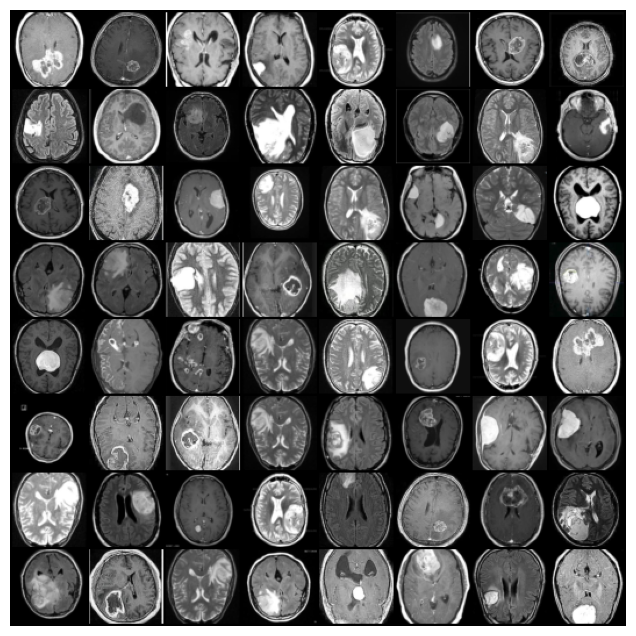

In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
device

device(type='cuda', index=0)

Weight Initialization

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Creating the Generator.

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

Creating the Discriminator.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Loss Functions and Optimizers.

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Now we are ready to create the training loop.

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
real_scores = []
fake_scores = []
iters = 0

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        # Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through Discriminator
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for Discriminator in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        #Train with all-fake batch

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with Generator
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with Discriminator
        output = netD(fake.detach()).view(-1)

        # Calculate Discriminator's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, summed with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of Discriminator as sum over the fake and the real batches
        errD = errD_real + errD_fake

        # Update Discriminator
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated Discriminator, perform another forward pass of all-fake batch through Discriminator
        output = netD(fake).view(-1)

        # Calculate Generator's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for Generator
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update Generator
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
          # Calculate scores for real and fake batches
            real_score = netD(real_cpu).mean().item()
            fake_score = netD(fake.detach()).mean().item()

            # Append scores to the lists
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
              fake = netG(fixed_noise).detach().cpu()
            for j in range(fake.shape[0]):
              img_list.append(fake[j])


        iters += 1

[0/300][0/12]	Loss_D: 1.9581	Loss_G: 7.7596	D(x): 0.4337	D(G(z)): 0.5501 / 0.0007
[1/300][0/12]	Loss_D: 7.9979	Loss_G: 14.9279	D(x): 0.0132	D(G(z)): 0.0000 / 0.0000
[2/300][0/12]	Loss_D: 2.5137	Loss_G: 9.2863	D(x): 0.3458	D(G(z)): 0.0009 / 0.0002
[3/300][0/12]	Loss_D: 0.4000	Loss_G: 5.5889	D(x): 0.8250	D(G(z)): 0.0703 / 0.0068
[4/300][0/12]	Loss_D: 0.4001	Loss_G: 4.8021	D(x): 0.7770	D(G(z)): 0.0395 / 0.0127
[5/300][0/12]	Loss_D: 1.0909	Loss_G: 17.4620	D(x): 0.9286	D(G(z)): 0.5716 / 0.0000
[6/300][0/12]	Loss_D: 0.4615	Loss_G: 8.6210	D(x): 0.7303	D(G(z)): 0.0006 / 0.0004
[7/300][0/12]	Loss_D: 0.3738	Loss_G: 7.5642	D(x): 0.9374	D(G(z)): 0.2352 / 0.0015
[8/300][0/12]	Loss_D: 0.3708	Loss_G: 7.0071	D(x): 0.9914	D(G(z)): 0.2298 / 0.0230
[9/300][0/12]	Loss_D: 0.0514	Loss_G: 9.2577	D(x): 0.9605	D(G(z)): 0.0004 / 0.0006
[10/300][0/12]	Loss_D: 0.0699	Loss_G: 5.6181	D(x): 0.9632	D(G(z)): 0.0159 / 0.0131
[11/300][0/12]	Loss_D: 0.0949	Loss_G: 4.3367	D(x): 0.9948	D(G(z)): 0.0815 / 0.0382
[12/300][0/1

Visualizing the Loss Graph

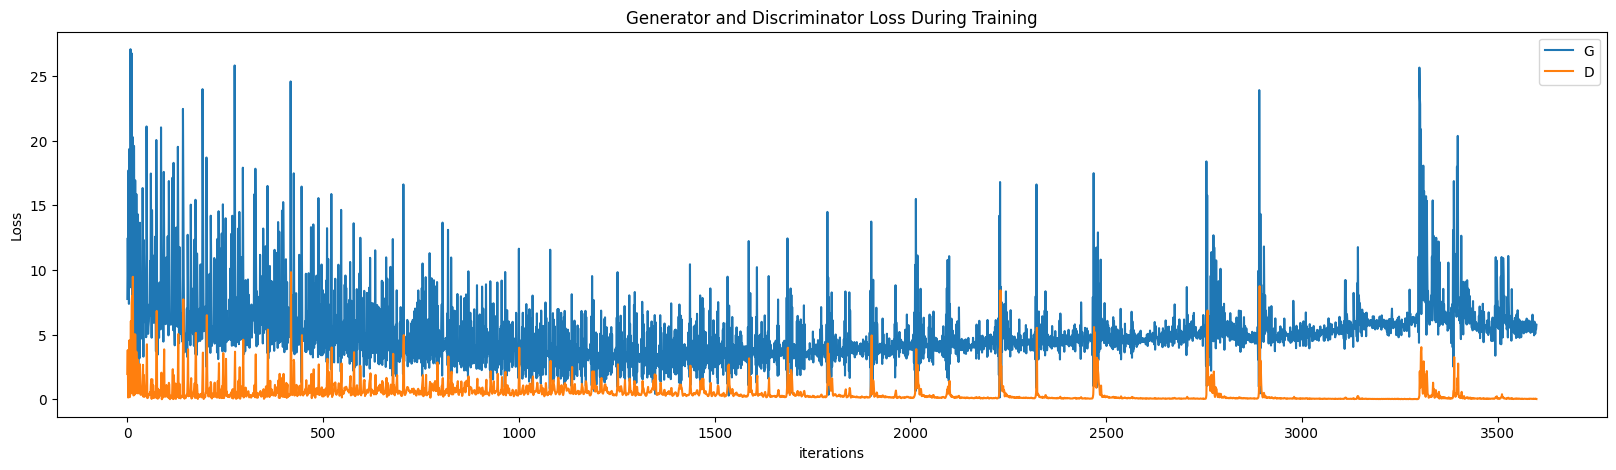

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

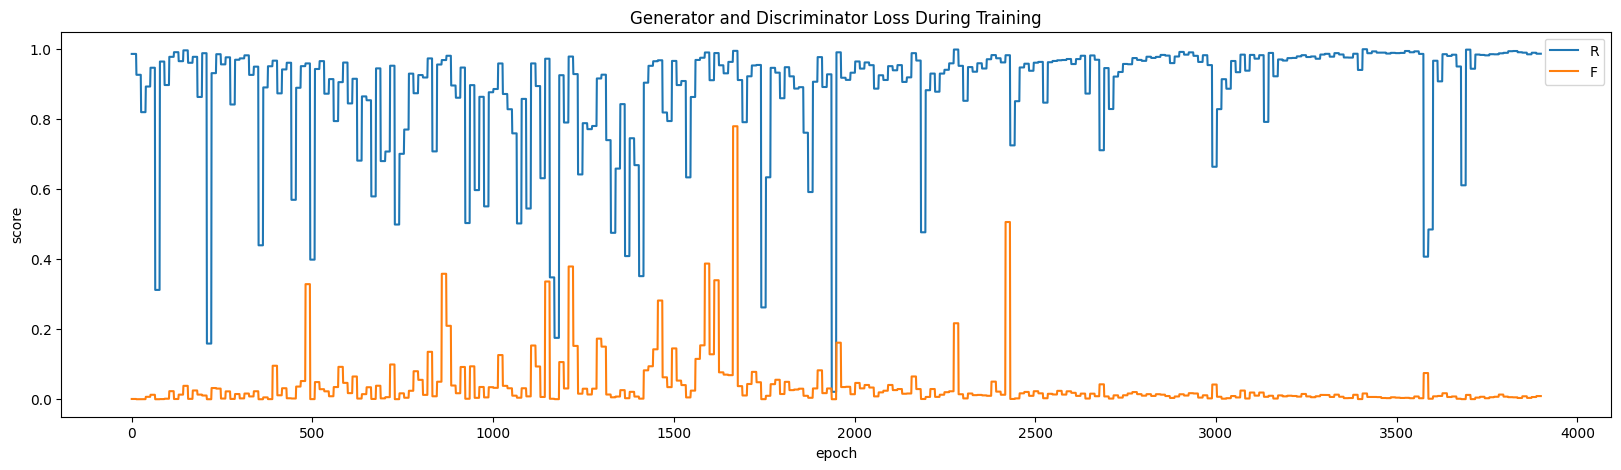

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(real_scores,label="R")
plt.plot(fake_scores,label="F")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend()
plt.show()

In [ ]:
# # Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# # Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# # Plot the fake images from the last epoch
# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(img_list[-1],(1,2,0)))
# plt.show()

In [ ]:
len(img_list)

576

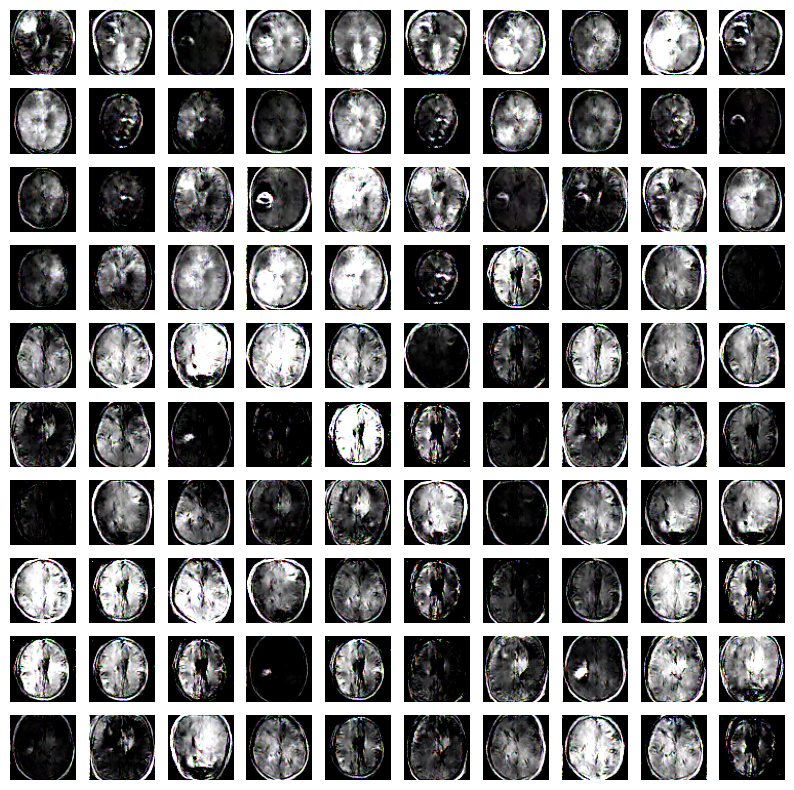

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the last 100 images in img_list
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    img = img_list[-100 + i]
    img = np.clip(img + 0.4, 0, 1)  # clip pixel values to [0, 1]
    row = i // 10
    col = i % 10
    axs[row][col].imshow(img.permute(1, 2, 0).numpy())
    axs[row][col].axis('off')

plt.show()


In [ ]:
import os

# Create a folder named "Fake" in the Google Drive
folder_path = "/content/drive/MyDrive/newYES"
os.makedirs(folder_path, exist_ok=True)

# Save the last 100 images to the "Fake" folder
for i in range(100):
    img = img_list[-100 + i]
    img_path = os.path.join(folder_path, f"fake_{i}.png")
    plt.imsave(img_path, np.clip(img.permute(1, 2, 0).numpy() + 0.4, 0, 1))
